In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import csv
import pandas as pd


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.optimizers import AdamW

c:\Users\user\anaconda3\envs\TF2\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
from enhance_model import enhance_net
from utils.training_process import training_process


# Load Data

In [4]:
epochs = 100
batch_size = 9
# 各模型極限batch size(3080Ti-12GB)
model_name = ['DCE','CSP_DCE', "MSP_DCE",'DCE++', 'Dil_DCE']
model_name = model_name[4]
add_noise = True
lr = 0.0001
# input_shape = (512,512,3)
model_path = './model/'

In [5]:
def process(image):
    image = tf.cast(image/255. ,tf.float32)
    return image

def process2(image, image2):
    image = tf.cast(image/255. ,tf.float32)
    image2 = tf.cast(image2/255. ,tf.float32)
    return image, image2

In [6]:
train_path = './Dataset/train'
validation_path = './Dataset/validation/'
validation_label_path = './Dataset/validation_label/'

# train_path = './Dataset/denoise/LOL/train/low/'
# validation_path = './Dataset/denoise/LOL/test/low/'
# validation_label_path = './Dataset/denoise/LOL/test/high/'

size = 512
trainset = image_dataset_from_directory(train_path,
                                        labels=None,
                                        label_mode=None,
                                        color_mode='rgb',
                                        class_names=None,
                                        image_size=(size,size),
                                        batch_size=batch_size,
                                        shuffle=False)

valset = image_dataset_from_directory(validation_path,
                                      seed=1,
                                      labels=None,
                                      label_mode=None,
                                      color_mode='rgb',
                                      class_names=None,
                                      image_size=(size,size),
                                      batch_size=batch_size)

val_label = image_dataset_from_directory(validation_label_path,
                                         seed=1,
                                         labels=None,
                                         label_mode=None,
                                         color_mode='rgb',
                                         class_names=None,
                                         image_size=(size,size),
                                         batch_size=batch_size)


valset = tf.data.Dataset.zip((valset, val_label))
valset = valset.map(process2)
trainset = trainset.map(process)

Found 3012 files belonging to 1 classes.
Found 778 files belonging to 1 classes.
Found 778 files belonging to 1 classes.


In [7]:
iterators = len(trainset)

# Build Model

In [8]:
model = enhance_net(input_shape=(None,None,3), model_name=model_name)
model.enhancement_net.summary()
# model.summary()

c:\Users\user\anaconda3\envs\TF2\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   224         ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   32          ['input_1[0][0]']                
                                8)                                                            

In [9]:
model.compile(optimizer=AdamW(learning_rate=lr,
                              clipvalue=0.1,
                              weight_decay=0.0001))

In [10]:
from IPython.display import clear_output

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(dataset=None, num=1):
    clear_output(wait=True)
    for image in dataset.take(num):
        enhancemnet_image, _ = model.predict(image)
        display([image[0], enhancemnet_image[0]])

1/1 [==============================] - 0s 202ms/step


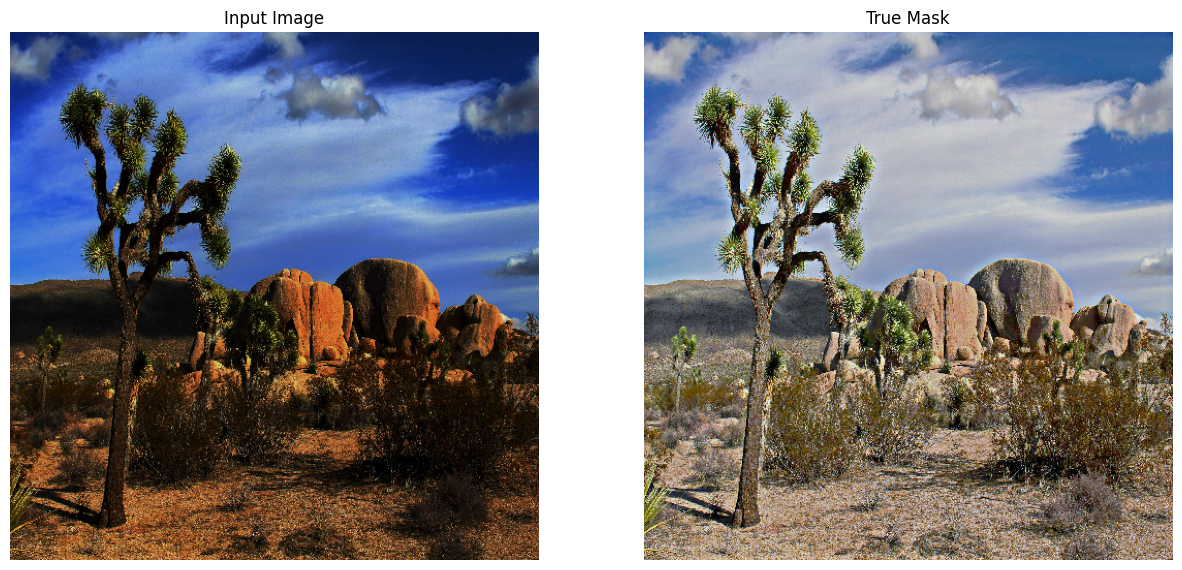


ssim: 0.489019 - psnr: 10.355992 - val_loss: 0.934123



In [11]:
best_ssim = 0
best_psnr = 0
best_val_loss = 0.0
val_loss_list = []  # 创建一个空的列表来存储每个epoch的val loss
psnr_list = []



#訓練迭代
for epoch in range(epochs):
    if epoch != 0:
        print()
    print('Epoch:{0}/{1}'.format(epoch+1,epochs))
    
    strat = time.time()
    # 預設最多會有10個評估參數
    mean_loss = np.zeros(10)
    
    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(trainset):
        # 呼叫訓練
        dict = model.train_step(x_batch_train)  
            
        # 輸出訓練過程(Epoch、step、time、total loss等參數)
        mean_loss = training_process(step, mean_loss, dict, len(trainset), strat, mode=1)  
    training_process(step, mean_loss, dict, len(trainset), strat, mode=2)
    
    show_predictions(trainset)
    #初始化所有數據
    mean_val_loss = 0.0
    mean_ssim = 0
    mean_psnr = 0
    for val, label in valset:
        ssim, psnr, val_loss = model.validation_step(val, label)
        mean_ssim += ssim.numpy()
        mean_psnr += psnr.numpy()
        mean_val_loss += val_loss.numpy()
    mean_ssim /= len(val_label)
    mean_psnr /= len(val_label)
    mean_val_loss /= len(val_label)
    val_loss_list.append(mean_val_loss)
    psnr_list.append(mean_psnr)
    print()

    # val_loss_str = '\n'.join([f'{v:.4f}' for v in val_loss_list])
    # psnr_str = '\n'.join([f'{p:.4f}' for p in psnr_list])
    # print(f'Val Loss:\n{val_loss_str}\n')
    # print(f'PSNR:\n{psnr_str}\n')

    val_psnr_list = [[v, p] for v, p in zip(val_loss_list, psnr_list)]
    val_psnr_str = '\n'.join([f'{v:.4f}, {p:.4f}' for v, p in val_psnr_list])

    with open('output.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Val Loss', 'PSNR'])
        writer.writerows(val_psnr_list)



    if mean_ssim > best_ssim and mean_psnr > best_psnr and mean_val_loss > best_val_loss :
        best_ssim = mean_ssim
        best_psnr = mean_psnr
        # best_val_loss = mean_val_loss
        model.model_save(epoch, model_path)
        print('save_model', end=' ')
        print('ssim: {0:6f} - psnr: {1:6f} - val_loss: {2:6f}'.format(best_ssim, best_psnr, best_val_loss))
        
    else:
        print('ssim: {0:6f} - psnr: {1:6f} - val_loss: {2:6f}'.format(mean_ssim, mean_psnr, mean_val_loss))
        
    if (epoch + 1) % 10 == 0:
        print()
        model.model_save(epoch, model_path)
    
  

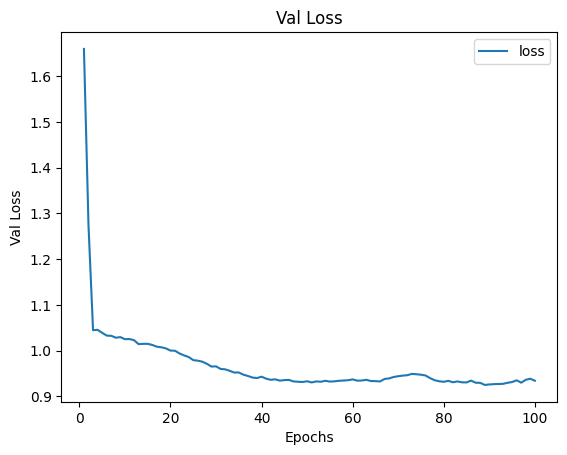

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv('output.csv')
data_loss = data[['Val Loss']] #class 'pandas.core.frame.DataFrame'
y = np.array(data_loss)#将DataFrame类型转化为numpy数组
x = list(range(1, 101))  # x 軸的數值為 0 到 100

plt.plot(x, y,label="loss")
plt.title("Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Val Loss")  # 設定 x 軸的範圍
plt.legend()   #显示标签
plt.show()
